In [4]:
import pandas as pd
import seaborn as sns

sns.set()

In [5]:
df = pd.read_csv('output.csv')
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df['Question ID'] = pd.Categorical(df['Question ID'],
                                   categories=sorted(df['Question ID'].value_counts().keys()),
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)
df["Given-Expected Answer Pair"] = pd.Categorical(df["Given-Expected Answer Pair"],
                                                 categories=sorted(df["Given-Expected Answer Pair"].value_counts().keys()),
                                                 ordered=True)

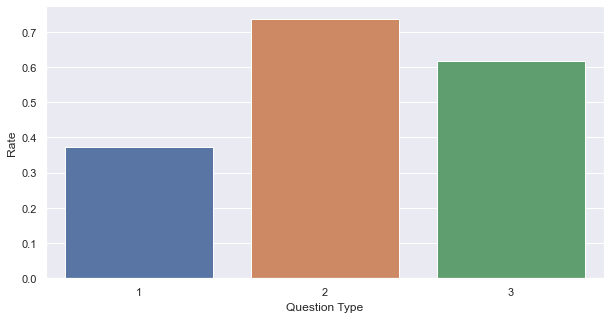

In [6]:
types = df.groupby("Question Type")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
sns.set(rc = {'figure.figsize':(10,5)})
g = sns.barplot(x= "Question Type", y= "Rate", data=df1.reset_index())

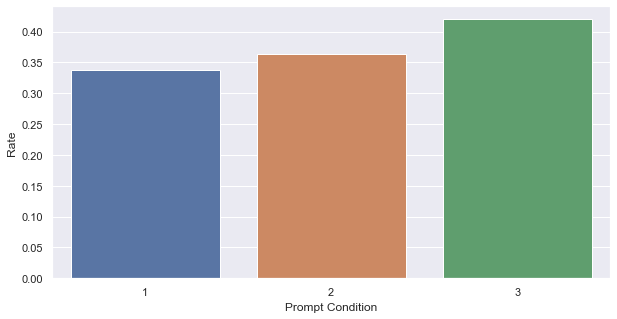

In [7]:
type1 = df[df["Question Type"] == 1]
types = type1.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())


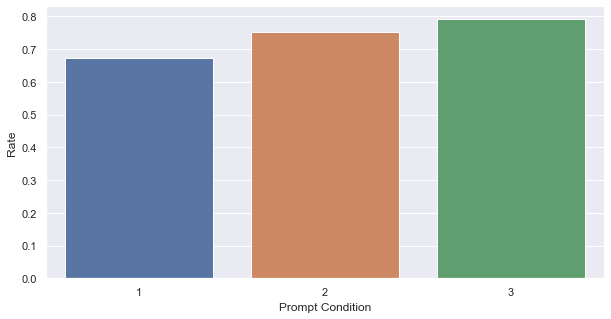

In [8]:
type2 = df[df["Question Type"] == 2]
types = type2.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())


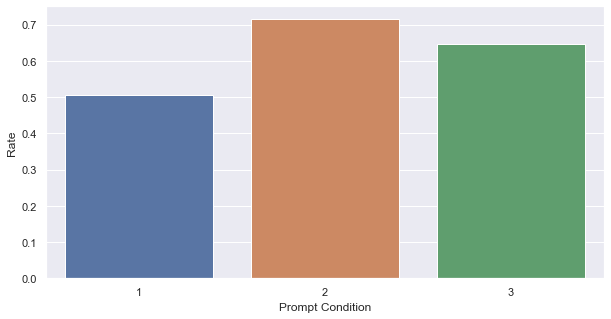

In [9]:
type3 = df[df["Question Type"] == 3]
types = type3.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())


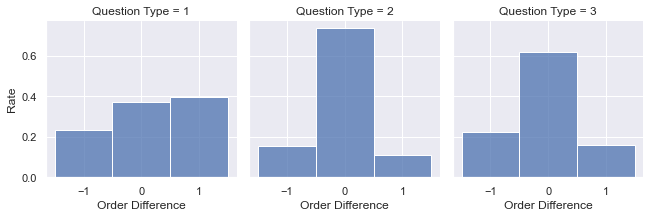

In [223]:
g = sns.FacetGrid(df, col = "Question Type")
graph = g.map_dataframe(sns.histplot, x = "Order Difference", stat="probability")
graph.set_xlabels("Order Difference")
graph.set_ylabels("Rate")


In [224]:
df1 = pd.read_csv('output2.csv')
df1["Correctness"] = df1["Correctness"].map({0: "Incorrect", 1:"Correct"})
df1['Correctness'] = pd.Categorical(df1['Correctness'],  categories=["Correct", "Incorrect"],
                                   ordered=True)

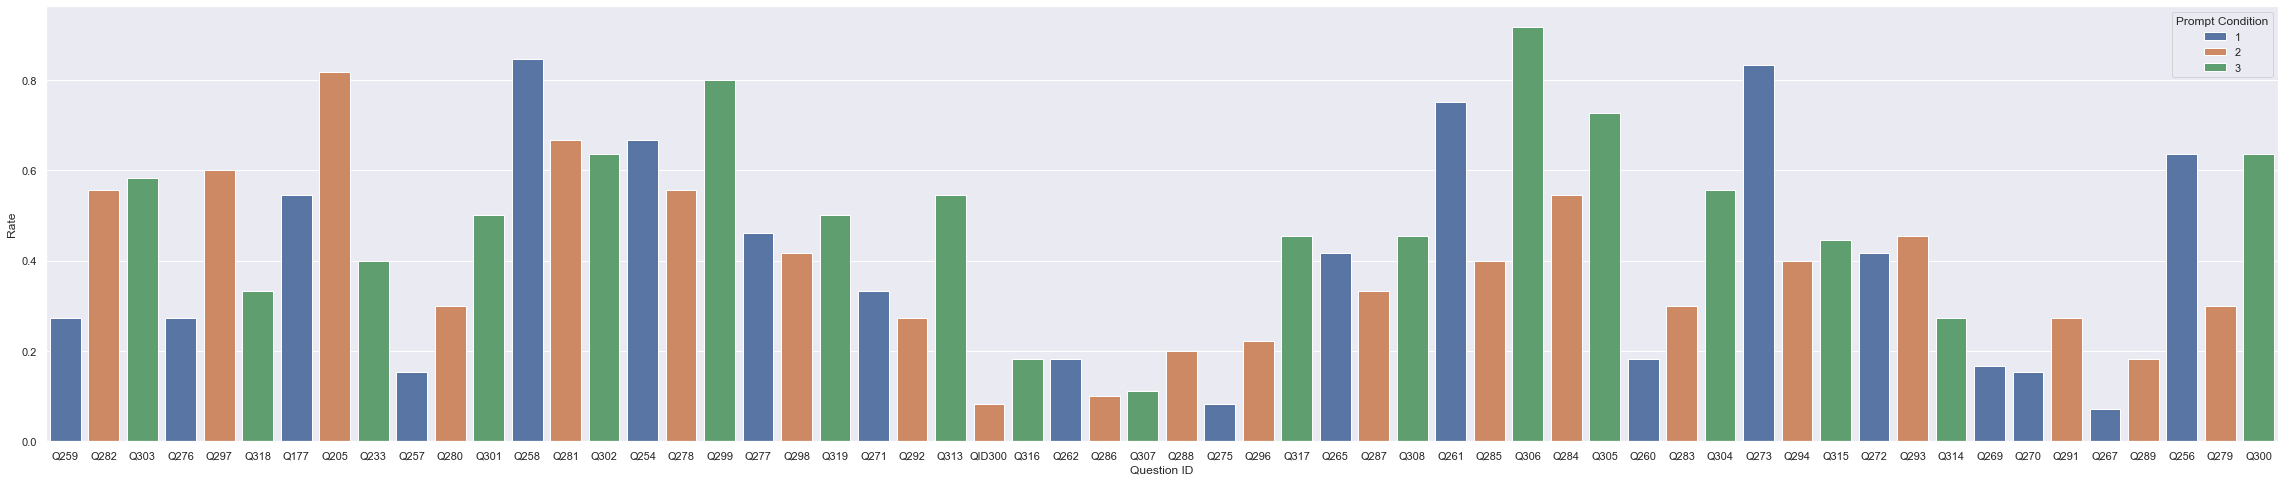

In [225]:
type1 = df1[df1["Question Type"] == 1]
type1 = type1.groupby(["Question Name", "Prompt Condition", "Question ID"])["Correctness"].value_counts(normalize=True)
types = pd.DataFrame(type1)
types = types.drop(labels=['Incorrect'], level = 3)
types = types.rename(columns={"Correctness" : "Rate"})
types = types.reset_index()
types = types.iloc[: , 1:]
types.to_csv("types.csv")
sns.set(rc = {'figure.figsize':(40,8)})
g = sns.barplot(x= "Question ID", y= "Rate", hue = "Prompt Condition", data=types, dodge = False)

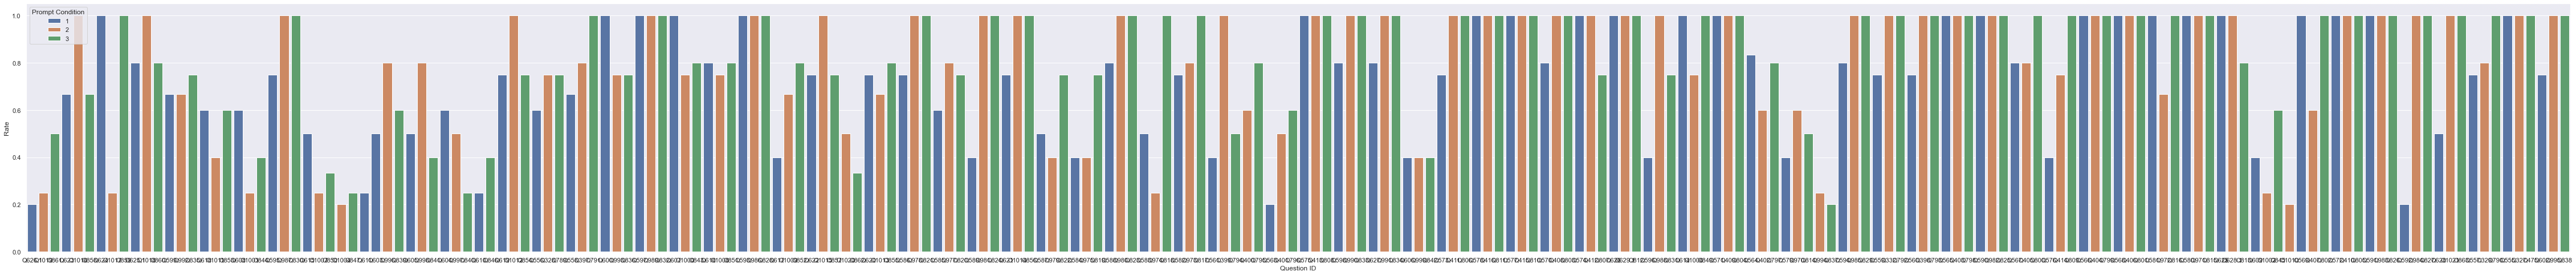

In [227]:
type2 = df1[df1["Question Type"] == 2]
type2 = type2.groupby(["Question Name", "Prompt Condition", "Question ID"])["Correctness"].value_counts(normalize=True)
types = pd.DataFrame(type2)
types.to_csv("types.csv")
types = types.drop(labels=['Incorrect'], level = 3)
types = types.rename(columns={"Correctness" : "Rate"})
types = types.reset_index()
types = types.iloc[: , 1:]
types.to_csv("types.csv")
sns.set(rc = {'figure.figsize':(80,8)})
g = sns.barplot(x= "Question ID", y= "Rate", hue = "Prompt Condition", data=types, dodge = False)


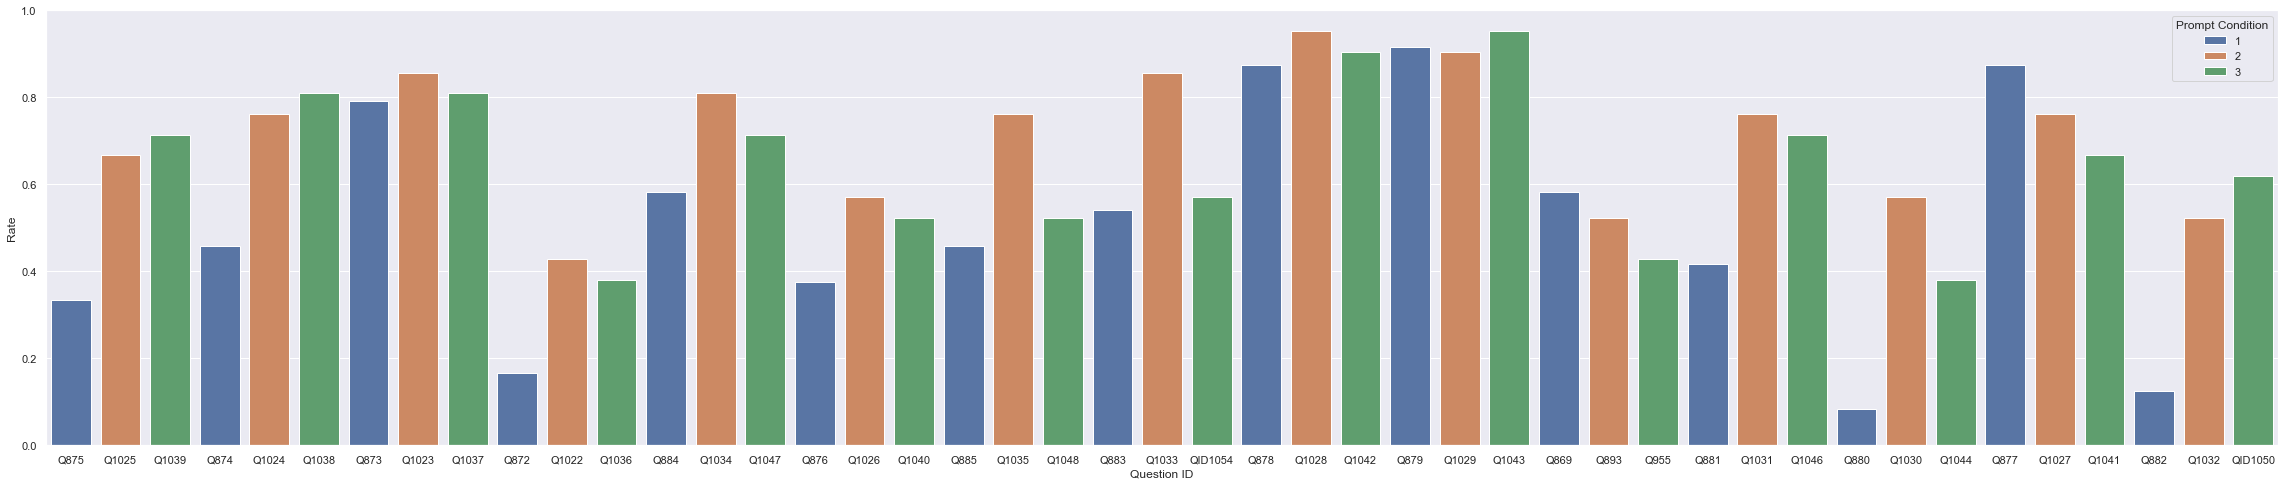

In [228]:
type3 = df1[df1["Question Type"] == 3]
type3 = type3.groupby(["Question Name", "Prompt Condition", "Question ID"])["Correctness"].value_counts(normalize=True)
types = pd.DataFrame(type3)
types = types.drop(labels=['Incorrect'], level = 3)
types = types.rename(columns={"Correctness" : "Rate"})
types = types.reset_index()
types = types.iloc[: , 1:]
sns.set(rc = {'figure.figsize':(40,8)})
g = sns.barplot(x= "Question ID", y= "Rate", hue = "Prompt Condition", data=types, dodge = False)

In [229]:
df = pd.read_csv('output.csv')
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)


Text(0.5, 0.98, 'Given-Expected Answer Pair')

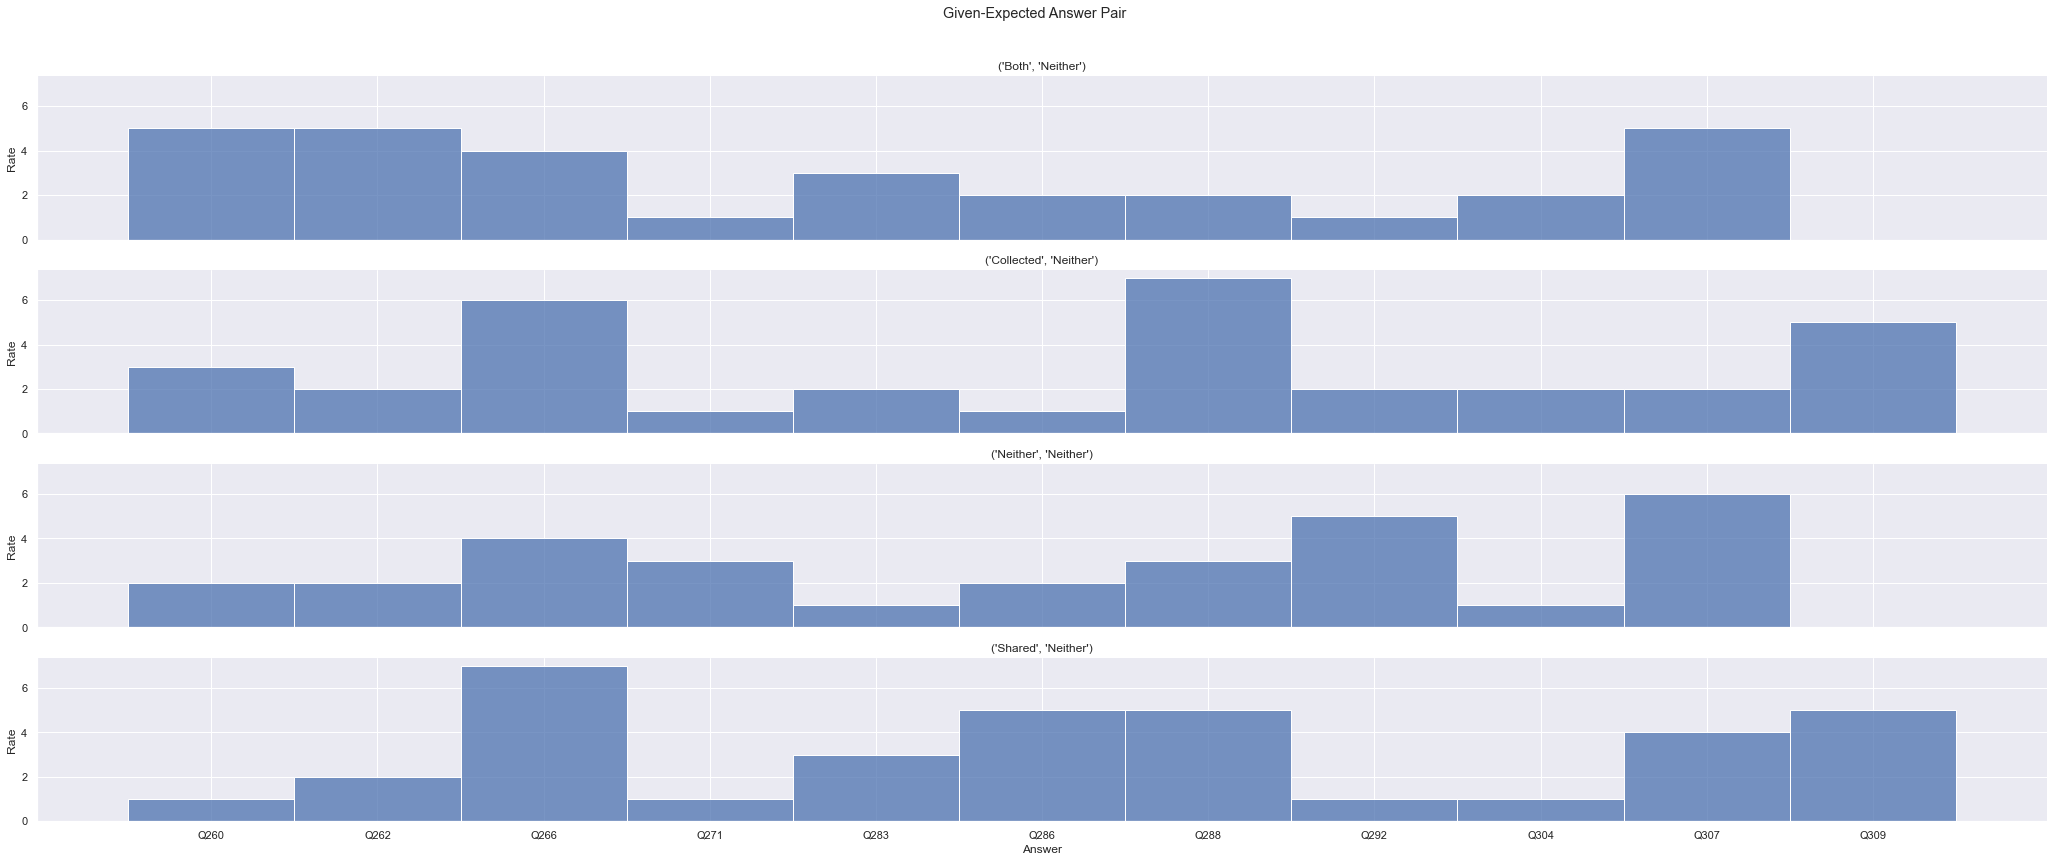

In [230]:
g = sns.FacetGrid(df[df["Correct Answer"] == "Neither"], col = "Given-Expected Answer Pair", col_wrap=1, aspect=9.5,
                 col_order=sorted(df[df["Correct Answer"] == "Neither"]["Given-Expected Answer Pair"].value_counts().keys()))
graph = g.map_dataframe(sns.histplot, x = "Question ID", stat="count")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Add a title for the entire plot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Given-Expected Answer Pair")

           Collected    Shared      Both   Neither
Collected   0.381609  0.212121  0.083969  0.259843
Shared      0.285057  0.303030  0.404580  0.275591
Both        0.252874  0.181818  0.496183  0.236220
Neither     0.080460  0.303030  0.015267  0.228346


[Text(0.5, 21.5, 'Correct Answer'), Text(66.5, 0.5, 'Answer')]

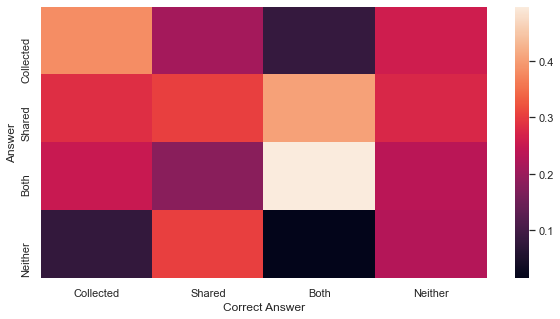

In [10]:
t1 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t1 = t1[t1["Question Type"] == 1]
t1 = t1.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t1.loc[:, "Correct Answer"]
actualAnswers = t1.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(j, i)] = answerPairs.get((j, i), 0) + 1
#create ratios for actual/correct answers
for (actual, correct) in answerPairs:
    answerPairs[(actual, correct)] = answerPairs[(actual, correct)] / correctTotals[correct]
rowNames = ["Collected", "Shared", "Both", "Neither"]
type1 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type1.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type1.at[rowNames[i], rowNames[j]] = 0
type1 = type1.astype(float)
print(type1)
g = sns.heatmap(type1)
g.set(xlabel= "Correct Answer", ylabel = "Answer")

[Text(0.5, 21.453125, 'Correct Answer'),
 Text(66.45312499999999, 0.5, 'Answer')]

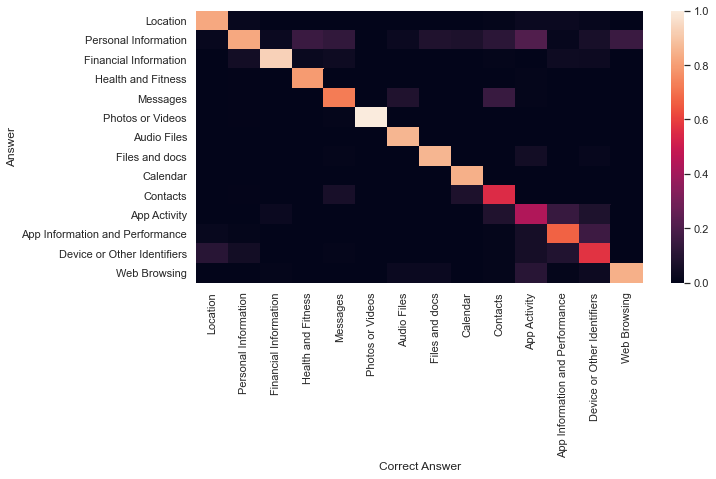

In [16]:
t2 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t2 = t2[t2["Question Type"] == 2]
t2 = t2.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t2.loc[:, "Correct Answer"]
actualAnswers = t2.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(j, i)] = answerPairs.get((j, i), 0) + 1
#create ratios for actual/correct answers
for (actual, correct) in answerPairs:
    answerPairs[(actual, correct)] = answerPairs[(actual, correct)] / correctTotals[correct]
rowNames = ["Location", "Personal Information", "Financial Information", "Health and Fitness", "Messages", "Photos or Videos", "Audio Files", "Files and docs", "Calendar", "Contacts", "App Activity", "App Information and Performance", "Device or Other Identifiers", "Web Browsing"]
type2 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type2.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type2.at[rowNames[i], rowNames[j]] = 0
type2 = type2.astype(float)
g = sns.heatmap(type2)
g.set(xlabel= "Correct Answer", ylabel = "Answer")


[Text(0.5, 21.453125, 'Correct Answer'),
 Text(66.45312499999999, 0.5, 'Answer')]

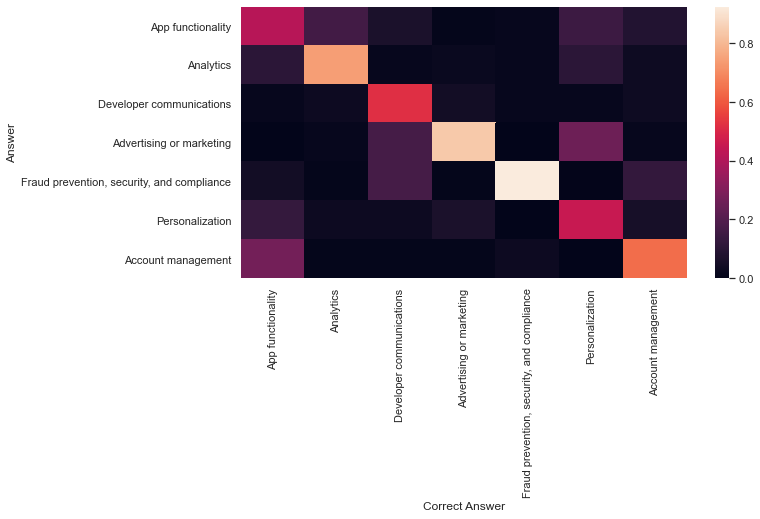

In [17]:
t3 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t3 = t3[t3["Question Type"] == 3]
t3 = t3.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t3.loc[:, "Correct Answer"]
actualAnswers = t3.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(j, i)] = answerPairs.get((j, i), 0) + 1
#create ratios for actual/correct answers
for (actual, correct) in answerPairs:
    answerPairs[(actual, correct)] = answerPairs[(actual, correct)] / correctTotals[correct]
rowNames = ["App functionality", "Analytics", "Developer communications", "Advertising or marketing", "Fraud prevention, security, and compliance", "Personalization", "Account management"]
type3 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type3.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type3.at[rowNames[i], rowNames[j]] = 0
type3 = type3.astype(float)
g = sns.heatmap(type3)
g.set(xlabel= "Correct Answer", ylabel = "Answer")
